In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import cv2

def interpolate_patch(image, corrupted_idx, method='linear'):
    h, w = image.shape
    i, j, dh, dw = corrupted_idx
    
    # Points to use for interpolation - the boundaries surrounding the corrupted patch
    mask = np.ones_like(image, dtype=bool)
    mask[i:i+dh, j:j+dw] = False
    y, x = np.nonzero(mask)
    points = np.array(list(zip(y, x)))
    values = image[y, x]
    
    # Points to interpolate
    grid_y, grid_x = np.mgrid[i:i+dh, j:j+dw]
    grid_points = np.array(list(zip(grid_y.ravel(), grid_x.ravel())))
    
    # Interpolation
    interpolated_values = griddata(points, values, grid_points, method=method).reshape(dh, dw)
    
    return interpolated_values

def reconstruct_image(image, corrupted_idx):
    h, w = image.shape
    i, j, dh, dw = corrupted_idx
    
    # Copy original image and prepare the plot
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    reconstructed = image.copy()
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Original Corrupted')
    axs[0].axis('off')

    # Interpolate from each non-corrupted part
    methods = ['nearest', 'linear', 'cubic']
    for k, method in enumerate(methods, 1):
        patch = interpolate_patch(image, corrupted_idx, method=method)
        reconstructed[i:i+dh, j:j+dw] = patch
        axs[k].imshow(patch, cmap='gray')
        axs[k].set_title(f'Patch via {method}')
        axs[k].axis('off')

    # Show reconstructed image
    reconstructed[i:i+dh, j:j+dw] = np.mean([interpolate_patch(image, corrupted_idx, method=m) for m in methods], axis=0)
    axs[4].imshow(reconstructed, cmap='gray')
    axs[4].set_title('Reconstructed Image')
    axs[4].axis('off')

    plt.show()
    return reconstructed

# Simulate an image with a corrupted patch
h, w = 100, 100
image = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE).astype(float)
i, j, dh, dw = 30, 30, 20, 20  # Corrupted patch coordinates
image[i:i+dh, j:j+dw] = np.nan  # Assume NaN represents corruption

# Reconstruct the image
corrupted_idx = (i, j, dh, dw)
reconstructed = reconstruct_image(image, corrupted_idx)

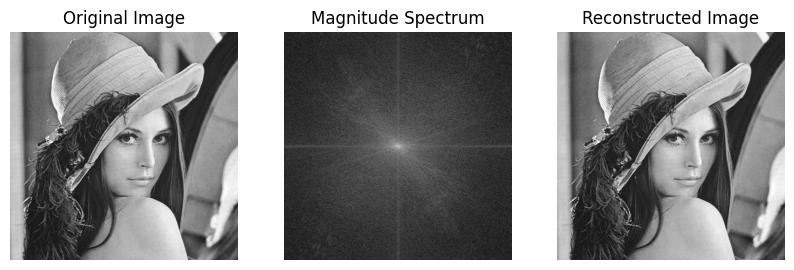

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy.fft as fft

def manual_inverse_fft_2d(F):
    N, M = F.shape
    n = np.arange(N)
    m = np.arange(M)
    k = n.reshape((N, 1))
    l = m.reshape((M, 1))
    # Create the 2D frequency bases for rows and columns
    exponent_row = np.exp(2j * np.pi * k * n / N)
    exponent_col = np.exp(2j * np.pi * l * m / M)
    # Apply IFFT by rows and then by columns
    intermediate = np.dot(exponent_row, F) / N
    return np.dot(intermediate, exponent_col.T) / M  # Note the transpose on exponent_col

# Load the image
image = imread('lenna.png')
if image.ndim == 3:
    image = image[:,:,0]  # Convert to grayscale if it's a color image

# Compute the FFT using numpy's built-in function
F = fft.fft2(image)

# Compute the inverse FFT manually
reconstructed_image = manual_inverse_fft_2d(F)

# Display the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.log(np.abs(fft.fftshift(F)) + 1), cmap='gray')
plt.title('Magnitude Spectrum')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.real(reconstructed_image), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()


In [ ]:
from darts.models import FFT
import cv2
from darts.timeseries import TimeSeries

img = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)
img = TimeSeries.from_values(img)
model = FFT(required_matches=set(), nr_freqs_to_keep=None)
model.fit(img)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from darts.models import FFT
from darts.timeseries import TimeSeries
from typing import Optional
import cv2

c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
class FFT2D:
    def __init__(self, nr_freqs_to_keep: Optional[int] = 10,
        required_matches: Optional[set] = None,
        trend: Optional[str] = None,
        trend_poly_degree: int = 3,):
        """
        Initialize the FFT model for images.
        
        Parameters:
        - nr_freqs_to_keep (int): Number of highest magnitude frequencies to keep.
        """
        self.nr_freqs_to_keep = nr_freqs_to_keep
        self.required_matches = required_matches
        self.trend = trend
        self.trend_poly_degree = trend_poly_degree

    def fit(self, image: np.ndarray):
        """
        Apply 2D FFT to the image and keep only the largest frequencies as specified by nr_freqs_to_keep.
        
        Parameters:
        - image (np.array): 2D array representing the grayscale image.
        """
        self.image = image
        self._models = [FFT(required_matches=self.required_matches, trend=self.trend, trend_poly_degree=self.trend_poly_degree) for _ in range(image.shape[0])]

        for i in range(image.shape[0]):
            self._models[i].fit(TimeSeries.from_values(image[i, :]))  # Reverse the horizontal axis if needed

        return self

    def predict(self, n: int, num_samples: int = 1, verbose: bool = False):
        """
        Predict the next n values in the time series.
        
        Parameters:
        - n (int): Number of time steps to predict.
        - num_samples (int): Number of samples to generate.
        - verbose (bool): Whether to print the progress of the prediction.
        - horizontal (bool): Whether to predict horizontally or vertically.
        
        Returns:
        - (np.array): Predicted values.
        """
        return np.hstack([self._models[i].predict(n, num_samples, verbose).data_array() for i in range(self.image.shape[0])]).astype(int).reshape(self.image.shape)

In [14]:
class FFTRepair:
    def __init__(self, image:np.ndarray, weight_func:str='equal'):
        """
        Initialize the FFTRepair model.
        
        Parameters:
        - image (np.array): 2D array representing the grayscale image.
        - weight_func (str): The weight function to use for combining the predictions.
        """
        self.image = image
        self.weight_func = weight_func

    def fit(self, index, width, height, nr_freqs_to_keep: Optional[int] = 10, required_matches: Optional[set] = None, trend: Optional[str] = None, trend_poly_degree: int = 3):
        """
        Fit the model to the corrupted patch.

        Parameters:
        - index (tuple): The top-left corner of the corrupted patch.
        - width (int): The width of the corrupted patch.
        - height (int): The height of the corrupted patch.
        - nr_freqs_to_keep (int): Number of highest magnitude frequencies to keep.
        - required_matches (set): Set of frequencies to keep.
        - trend (str): The trend to remove from the time series.
        - trend_poly_degree (int): The degree of the polynomial to fit the trend.
        """
        left = self.image[index[0]:index[0]+height, max(0,index[1]-width):index[1]]
        right = self.image[index[0]:index[0]+height, index[1]+width:min(index[1]+2*width, self.image.shape[1])]
        top = self.image[max(0, index[0]-height):index[0], index[1]:index[1]+width]
        bottom = self.image[index[0]+height:min(index[0]+2*height,self.image.shape[0]), index[1]:index[1]+width]

        self.left_model = FFT2D(nr_freqs_to_keep, required_matches, trend, trend_poly_degree).fit(left)
        self.right_model = FFT2D(nr_freqs_to_keep, required_matches, trend, trend_poly_degree).fit(np.flip(right, axis=1)) # Reverse the horizontal axis
        self.top_model = FFT2D(nr_freqs_to_keep, required_matches, trend, trend_poly_degree).fit(np.transpose(top)) # Transpose the array
        self.bottom_model = FFT2D(nr_freqs_to_keep, required_matches, trend, trend_poly_degree).fit(np.rot90(bottom, -1)) # Rotate the array 90 degrees clockwise

        self.part_height = height
        self.part_width = width

        return self
    
    def predict(self, num_samples: int = 1, verbose: bool = False):
        """
        Predict the missing patch.
        
        Parameters:
        - num_samples (int): Number of samples to generate.
        - verbose (bool): Whether to print the progress of the prediction.
        """

        left = self.left_model.predict(self.part_width, num_samples, verbose)
        right = np.flip(self.right_model.predict(self.part_height, num_samples, verbose),axis=1) # Reverse the horizontal axis
        top = np.transpose(self.top_model.predict(self.part_height, num_samples, verbose)) # Transpose the array
        bottom = np.rot90(self.bottom_model.predict(self.part_height, num_samples, verbose),1) # Rotate the array 90 degrees counterclockwise

        # Compute distance-based weights
        vertical_weights = np.linspace(1, 1e-3, self.part_height).reshape(-1, 1)
        horizontal_weights = np.linspace(1, 1e-3, self.part_width).reshape(1, -1)

        # Apply weights to predictions
        weighted_left = left * horizontal_weights
        weighted_right = right * np.flip(horizontal_weights, axis=1)
        weighted_top = top * vertical_weights
        weighted_bottom = bottom * np.flip(vertical_weights, axis=0)

        if self.weight_func == 'equal':
            combined_prediction = (left + right + top + bottom) / 4
        elif self.weight_func == 'distance':
            weighted_sum = (weighted_left + weighted_right + weighted_top + weighted_bottom)
            horizontal_weights_full = np.tile(horizontal_weights, (self.part_height, 1))
            vertical_weights_full = np.tile(vertical_weights, (1, self.part_width))

            weights_sum = horizontal_weights_full + np.flip(horizontal_weights_full, axis=1) + vertical_weights_full + np.flip(vertical_weights_full, axis=0)

            # weights_sum = (horizontal_weights + horizontal_weights + vertical_weights + vertical_weights)
            combined_prediction = weighted_sum / weights_sum
        else:
            raise ValueError('Invalid weight function')

        return combined_prediction.astype(int)

In [34]:
index = (100,50)
width, height = 20, 20
img = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)
corrupted = img[index[0]:index[0]+height,index[1]:index[1]+width]
model = FFTRepair(img, weight_func='distance').fit(index, width, height, nr_freqs_to_keep=20, required_matches=None, trend=None, trend_poly_degree=3)
predicted= model.predict()

In [35]:
cpy_img = img.copy()
cpy_img[index[0]:index[0]+height,index[1]:index[1]+width] = predicted.reshape(height,width)

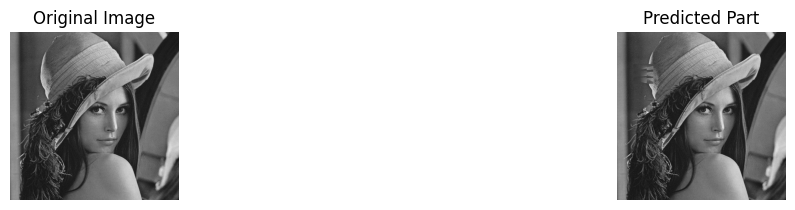

In [39]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# plt.subplot(1, 4, 2)
# plt.imshow(corrupted, cmap='gray')
# plt.title('Corrupted Part')
# plt.axis('off')

# plt.subplot(1, 4, 3)
# plt.imshow(predicted, cmap='gray')
# plt.title('Predicted Part')
# plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(cpy_img, cmap='gray')
plt.title('Predicted Part')
plt.axis('off')

plt.show()

In [17]:
from darts.models.forecasting.forecasting_model import GlobalForecastingModel
from darts.timeseries import TimeSeries
from typing import Optional, Callable, Sequence, Union, Tuple, List
import numpy as np
from darts.utils.missing_values import fill_missing_values
from darts.models.forecasting.fft import _find_relevant_timestamp_attributes, _crop_to_match_seasons
import cv2
import matplotlib.pyplot as plt

In [39]:
class FFT2(GlobalForecastingModel):
    def __init__(
        self,
        nr_freqs_to_keep: Optional[int] = 10,
        required_matches: Optional[set] = None,
        trend: Optional[str] = None,
        trend_poly_degree: int = 3,
    ):
        """Fast Fourier Transform Model

        This model performs forecasting on a TimeSeries instance using FFT, subsequent frequency filtering
        (controlled by the `nr_freqs_to_keep` argument) and  inverse FFT, combined with the option to detrend
        the data (controlled by the `trend` argument) and to crop the training sequence to full seasonal periods
        Note that if the training series contains any NaNs (missing values), these will be filled using
        :func:`darts.utils.missing_values.fill_missing_values()`.

        Parameters
        ----------
        nr_freqs_to_keep
            The total number of frequencies that will be used for forecasting.
        required_matches
            The attributes of pd.Timestamp that will be used to create a training sequence that is cropped at the
            beginning such that the first timestamp of the training sequence and the first prediction point have
            matching phases. If the series has a yearly seasonality, include `month`, if it has a monthly
            seasonality, include `day`, etc. If not set, or explicitly set to None, the model tries to find the
            pd.Timestamp attributes that are relevant for the seasonality automatically.
        trend
            If set, indicates what kind of detrending will be applied before performing DFT.
            Possible values: 'poly', 'exp' or None, for polynomial trend, exponential trend or no trend, respectively.
        trend_poly_degree
            The degree of the polynomial that will be used for detrending, if `trend='poly'`.

        Examples
        --------
        Automatically detect the seasonal periods, uses the 10 most significant frequencies for
        forecasting and expect no global trend to be present in the data:

        >>> FFT(nr_freqs_to_keep=10)

        Assume the provided TimeSeries instances will have a monthly seasonality and an exponential
        global trend, and do not perform any frequency filtering:

        >>> FFT(required_matches={'month'}, trend='exp')

        Simple usage example, using one of the dataset available in darts
        >>> from darts.datasets import AirPassengersDataset
        >>> from darts.models import FFT
        >>> series = AirPassengersDataset().load()
        >>> # increase the number of frequency and use a polynomial trend of degree 2
        >>> model = FFT(
        >>>     nr_freqs_to_keep=20,
        >>>     trend= "poly",
        >>>     trend_poly_degree=2
        >>> )
        >>> model.fit(series)
        >>> pred = model.predict(6)
        >>> pred.values()
        array([[471.79323146],
               [494.6381425 ],
               [504.5659999 ],
               [515.82463265],
               [520.59404623],
               [547.26720705]])

        .. note::
            `FFT example notebook <https://unit8co.github.io/darts/examples/03-FFT-examples.html>`_ presents techniques
            that can be used to improve the forecasts quality compared to this simple usage example.
        """
        super().__init__()
        self.nr_freqs_to_keep = nr_freqs_to_keep
        self.required_matches = required_matches
        self.trend = trend
        self.trend_poly_degree = trend_poly_degree

    @property
    def _model_encoder_settings(
        self,
    ) -> Tuple[
        Optional[int],
        Optional[int],
        bool,
        bool,
        Optional[List[int]],
        Optional[List[int]],
    ]:
        return None, None, False, False, None, None

    @property
    def extreme_lags(
        self,
    ) -> Tuple[
        Optional[int],
        Optional[int],
        Optional[int],
        Optional[int],
        Optional[int],
        Optional[int],
    ]:
        # TODO: LocalForecastingModels do not yet handle extreme lags properly. Especially
        #  TransferableFutureCovariatesLocalForecastingModel, where there is a difference between fit and predict mode)
        #  do not yet. In general, Local models train on the entire series (input=output), different to Global models
        #  that use an input to predict an output.
        return -self.min_train_series_length, -1, None, None, None, None
    
    @property
    def supports_multivariate(self) -> bool:
        return True

    def _exp_trend(self, x) -> Callable:
        """Helper function, used to make FFT model pickable."""
        return np.exp(self.trend_coefficients[1]) * np.exp(
            self.trend_coefficients[0] * x
        )

    def _poly_trend(self, trend_coefficients) -> Callable:
        """Helper function, for consistency with the other trends"""
        return np.poly1d(trend_coefficients)

    def _null_trend(self, x) -> Callable:
        """Helper function, used to make FFT model pickable."""
        return 0

    def fit(self, series: Union[TimeSeries, Sequence[TimeSeries]]):
        series = fill_missing_values(series)
        super().fit(series)
        # self._assert_univariate(series)
        series = self.training_series

        # determine trend
        if self.trend == "poly":
            self.trend_coefficients = np.polyfit(
                range(len(series)), series.univariate_values(), self.trend_poly_degree
            )
            self.trend_function = self._poly_trend(self.trend_coefficients)
        elif self.trend == "exp":
            self.trend_coefficients = np.polyfit(
                range(len(series)), np.log(series.univariate_values()), 1
            )
            self.trend_function = self._exp_trend
        else:
            self.trend_coefficients = None
            self.trend_function = self._null_trend

        # subtract trend
        detrended_values = series.values()
        # detrended_values = series.univariate_values() - self.trend_function(
        #     range(len(series))
        # )
        detrended_series = TimeSeries.from_times_and_values(
            series.time_index, detrended_values
        )

        # crop training set to match the seasonality of the first prediction point
        if self.required_matches is None:
            curr_required_matches = _find_relevant_timestamp_attributes(
                detrended_series
            )
        else:
            curr_required_matches = self.required_matches
        cropped_series = _crop_to_match_seasons(
            detrended_series, required_matches=curr_required_matches
        )

        # perform dft
        self.fft_values = np.fft.fft2(cropped_series.values()) #cropped_series.univariate_values())

        # get indices of `nr_freqs_to_keep` (if a correct value was provided) frequencies with the highest amplitudes
        # by partitioning around the element with sorted index -nr_freqs_to_keep instead of sorting the whole array
        first_n = self.nr_freqs_to_keep
        if first_n is None or first_n < 1 or first_n > len(self.fft_values.flatten()):
            first_n = len(self.fft_values.flatten())
        # self.filtered_indices = np.argpartition(abs(self.fft_values), -first_n)[
        #     -first_n:
        # ]
        flat_indices = np.argpartition(abs(self.fft_values).ravel(), -first_n)[-first_n:]
        self.filtered_indices = np.unravel_index(flat_indices, self.fft_values.shape)

        # set all other values in the frequency domain to 0
        self.fft_values_filtered = np.zeros_like(self.fft_values, dtype=np.complex_)
        self.fft_values_filtered[self.filtered_indices] = self.fft_values[
            self.filtered_indices
        ]

        # precompute all possible predicted values using inverse dft
        self.predicted_values = np.fft.ifft2(self.fft_values_filtered).real

        return self

    def predict(self, n: int, num_samples: int = 1, verbose: bool = False):
        super().predict(n, num_samples)
        # trend_forecast = np.array(
        #     [self.trend_function(i + len(self.training_series)) for i in range(n)]
        # )
        periodic_forecast = np.array(
            [self.predicted_values[i % len(self.predicted_values)] for i in range(n)]
        )
        return self._build_forecast_series(periodic_forecast).values() # + trend_forecast).values()

In [40]:
class FFTRepair:
    def __init__(self, image:np.ndarray, weight_func:str='equal'):
        """
        Initialize the FFTRepair model.
        
        Parameters:
        - image (np.array): 2D array representing the grayscale image.
        - weight_func (str): The weight function to use for combining the predictions.
        """
        self.image = image
        self.weight_func = weight_func

    def fit(self, index, width, height, nr_freqs_to_keep: Optional[int] = 10, required_matches: Optional[set] = None, trend: Optional[str] = None, trend_poly_degree: int = 3):
        """
        Fit the model to the corrupted patch.

        Parameters:
        - index (tuple): The top-left corner of the corrupted patch.
        - width (int): The width of the corrupted patch.
        - height (int): The height of the corrupted patch.
        - nr_freqs_to_keep (int): Number of highest magnitude frequencies to keep.
        - required_matches (set): Set of frequencies to keep.
        - trend (str): The trend to remove from the time series.
        - trend_poly_degree (int): The degree of the polynomial to fit the trend.
        """
        left = self.image[index[0]:index[0]+height, 0:index[1]] # self.image[index[0]:index[0]+height, max(0,index[1]-width):index[1]]
        right = self.image[index[0]:index[0]+height, index[1]+width:self.image.shape[1]] # self.image[index[0]:index[0]+height, index[1]+width:min(index[1]+2*width, self.image.shape[1])]
        top = self.image[0:index[0], index[1]:index[1]+width] # self.image[max(0, index[0]-height):index[0], index[1]:index[1]+width]
        bottom = self.image[index[0]+height:self.image.shape[0], index[1]:index[1]+width] # self.image[index[0]+height:min(index[0]+2*height,self.image.shape[0]), index[1]:index[1]+width]

        self.left_model = FFT2(nr_freqs_to_keep, required_matches, trend, trend_poly_degree).fit(TimeSeries.from_values(left))
        self.right_model = FFT2(nr_freqs_to_keep, required_matches, trend, trend_poly_degree).fit(TimeSeries.from_values(np.flip(right, axis=1))) # Reverse the horizontal axis
        self.top_model = FFT2(nr_freqs_to_keep, required_matches, trend, trend_poly_degree).fit(TimeSeries.from_values(np.transpose(top))) # Transpose the array
        self.bottom_model = FFT2(nr_freqs_to_keep, required_matches, trend, trend_poly_degree).fit(TimeSeries.from_values(np.rot90(bottom, -1))) # Rotate the array 90 degrees clockwise

        self.part_height = height
        self.part_width = width

        return self
    
    def predict(self, num_samples: int = 1, verbose: bool = False):
        """
        Predict the missing patch.
        
        Parameters:
        - num_samples (int): Number of samples to generate.
        - verbose (bool): Whether to print the progress of the prediction.
        """

        left = self.left_model.predict(self.part_width, num_samples, verbose)
        right = np.flip(self.right_model.predict(self.part_height, num_samples, verbose),axis=1) # Reverse the horizontal axis
        top = np.transpose(self.top_model.predict(self.part_height, num_samples, verbose)) # Transpose the array
        bottom = np.rot90(self.bottom_model.predict(self.part_height, num_samples, verbose),1) # Rotate the array 90 degrees counterclockwise

        # Compute distance-based weights
        vertical_weights = np.linspace(1, 1e-3, self.part_height).reshape(-1, 1)
        horizontal_weights = np.linspace(1, 1e-3, self.part_width).reshape(1, -1)

        # Apply weights to predictions
        weighted_left = left * horizontal_weights
        weighted_right = right * np.flip(horizontal_weights, axis=1)
        weighted_top = top * vertical_weights
        weighted_bottom = bottom * np.flip(vertical_weights, axis=0)

        if self.weight_func == 'equal':
            combined_prediction = (left + right + top + bottom) / 4
        elif self.weight_func == 'distance':
            weighted_sum = (weighted_left + weighted_right + weighted_top + weighted_bottom)
            horizontal_weights_full = np.tile(horizontal_weights, (self.part_height, 1))
            vertical_weights_full = np.tile(vertical_weights, (1, self.part_width))

            weights_sum = horizontal_weights_full + np.flip(horizontal_weights_full, axis=1) + vertical_weights_full + np.flip(vertical_weights_full, axis=0)

            # weights_sum = (horizontal_weights + horizontal_weights + vertical_weights + vertical_weights)
            combined_prediction = weighted_sum / weights_sum
        else:
            raise ValueError('Invalid weight function')

        return combined_prediction.astype(int)

In [43]:
    
index = (100,50)
width, height = 20, 20
img = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)
corrupted = img[index[0]:index[0]+height,index[1]:index[1]+width]
model = FFTRepair(img, weight_func='distance').fit(index, width, height, nr_freqs_to_keep=20, required_matches=None, trend=None, trend_poly_degree=3)
predicted= model.predict()

ValueError: operands could not be broadcast together with shapes (20,50) (1,20) 

In [ ]:
cpy_img = img.copy()
cpy_img[index[0]:index[0]+height,index[1]:index[1]+width] = predicted.reshape(height,width)

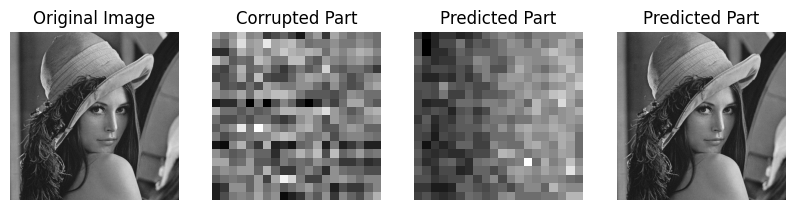

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(corrupted, cmap='gray')
plt.title('Corrupted Part')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(predicted, cmap='gray')
plt.title('Predicted Part')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(cpy_img, cmap='gray')
plt.title('Predicted Part')
plt.axis('off')

plt.show()

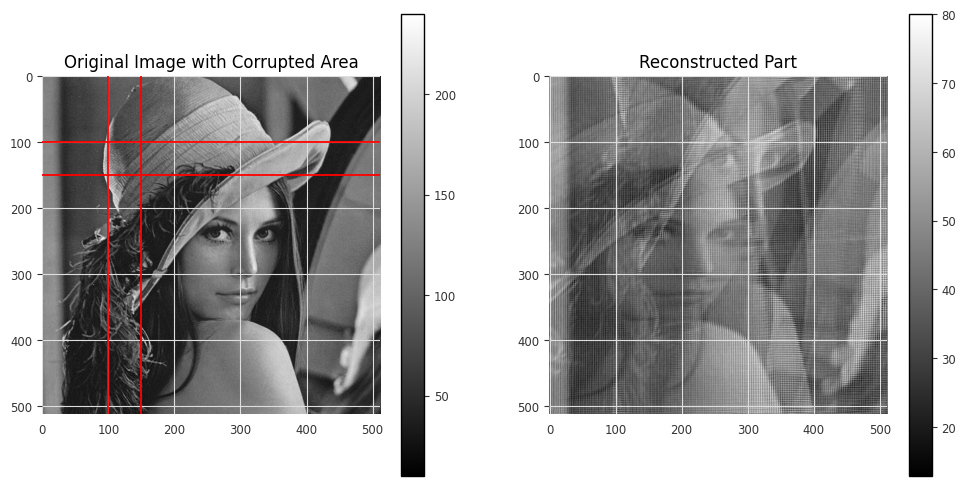

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Example parameters for the corrupted area (x, y, width, height)
corrupted_x, corrupted_y, corrupted_width, corrupted_height = 100, 100, 50, 50
image = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)  # Example image; replace with your actual image

# Define the four regions
left = image[:, :corrupted_x]
right = image[:, corrupted_x + corrupted_width:]
top = image[:corrupted_y, :]
bottom = image[corrupted_y + corrupted_height:, :]

regions = [left, right, top, bottom]

def pad_arrays_to_same_size(arrays):
    # Determine the maximum size in each dimension
    max_rows = max(arr.shape[0] for arr in arrays)
    max_cols = max(arr.shape[1] for arr in arrays)
    
    # Pad each array to the max size
    padded_arrays = [np.pad(arr, ((0, max_rows - arr.shape[0]), (0, max_cols - arr.shape[1])), mode='constant', constant_values=0) for arr in arrays]
    return padded_arrays

# Applying FFT on each region
fft_results = [np.fft.fft2(region) for region in regions]

# Pad FFT results to the same size
fft_results_padded = pad_arrays_to_same_size(fft_results)

# Compute magnitudes
fft_magnitudes = [np.abs(fft) for fft in fft_results_padded]

# Sum magnitudes to find common frequencies
frequency_sum = np.sum(fft_magnitudes, axis=0)
common_frequencies = frequency_sum > np.percentile(frequency_sum, 95)  # Example threshold: top 5%

# Example reconstruction code using the average common frequencies (adjust as needed)
average_fft = np.mean([fft * (frequency_sum > np.percentile(frequency_sum, 95)) for fft in fft_results_padded], axis=0)
reconstructed_full  = np.fft.ifft2(average_fft).real

reconstructed_part = reconstructed_full[
    :corrupted_height, :corrupted_width
]

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Original Image with Corrupted Area')
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.axhline(corrupted_y, color='r')
plt.axhline(corrupted_y + corrupted_height, color='r')
plt.axvline(corrupted_x, color='r')
plt.axvline(corrupted_x + corrupted_width, color='r')

plt.subplot(122)
plt.title('Reconstructed Part')
plt.imshow(reconstructed_part, cmap='gray')
plt.colorbar()
plt.show()